# Ecuación de Difusión en 2D implícito en Mallas Lógicamente Rectangulares

Función que calcula una aproximación a la solución de la ecuación de Difusión en 2D utilizando un esquema implícito de Diferencias Finitas Generalizadas en mallas lógicamente rectangulares.

El problema que se resuelve es:

\begin{align}
\frac{\partial u}{\partial t}= \nu\nabla^2 u
\end{align}

El número de vecinos varia dependiendo del nodo.

### Parámetros de entrada
    x           m x n       double      Matriz con las coordenadas en $x$ de los nodos.
    y           m x n       double      Matriz con las coordenadas de $y$ de los nodos.
    fDIF                    function    Función declarada con la condición inicial y de frontera.
    v                       real        Coeficiente de difusión.
    t                       integer     Número de pasos en el tiempo.

### Parámetros de salida
    u_ap        m x 1       double      Vector con la aproximación calculada por el método.
    u_ex        m x 1       double      Vector con la solución exacta del problema.

In [112]:
# Se elige la nube en la que se va a trabajar
malla = 'CAB21'

# Se elige el tamaño de la discretización temporal
t   = 1000

# Se elige el coeficiente de difusion
nu = 0.4

## Inicialización del Problema
Se inicializa lo necesario para el problema:


1.   Se importan las librerías necesarias.
2.   Se cargan los datos de la región.
3.   Se definen las condiciones iniciales y de frontera.

In [92]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sys import path
path.insert(0, '../Generales/')
from Errores import Mesh_Transient as ECM
#from Graficar import Mesh_Transient as Graph
from Graficar import Error as GraphEr
from scipy.io import loadmat
import scipy.sparse

### Se cargan los datos de la region

En esta parte se cargan los datos de la region desde un archivo .mat y se guardan en sus respectivas variables $x$ y $y$.

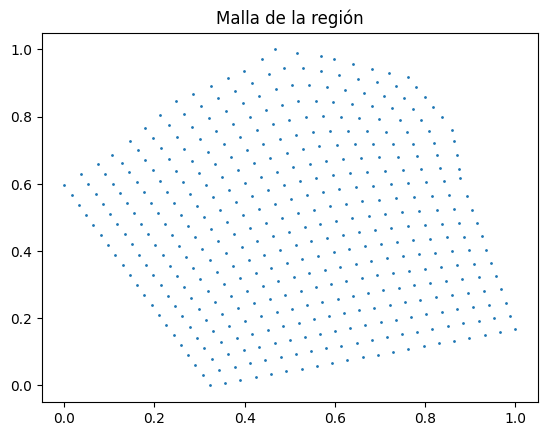

In [7]:
# Se cargan todos los datos desde el archivo
mat = loadmat('../Regiones/Mallas/' + malla + '.mat')

# Se guardan los datos de los nodos
x = mat['x']
y = mat['y']

# Se imprimen los nodos para asegurarnos de que se cargan correctamente.
plt.scatter(x,  y,  s = 1)
plt.title('Malla de la región')
plt.show()

### Se definen las condiciones iniciales y de frontera

Las condiciones iniciales y de frontera serán definidas como:
\begin{align}
  f = e^{-2*\pi^2vt}\cos(\pi x)cos(\pi y)
\end{align}

In [8]:
def fDIF(x, y, t, v):
    fun = math.exp(-2*math.pi**2*v*t)*math.cos(math.pi*x)*math.cos(math.pi*y)
    return fun

## Diferencias Finitas Generalizadas
Se resuelve el problema de Diferencias Finitas Generalizadas.

In [188]:
def KDiff(x, y, L):
    me = x.shape                                                                    # Se encuentra el tamaño de la malla.
    m  = me[0]                                                                      # Se encuentra el número de nodos en x.
    n  = me[1]                                                                      # Se encuentra el número de nodos en y.
    K  = np.zeros([m*n, m*n])                                                       # Se define la matríz K que guardará la estructura de las Diferencias Finitas Generalizadas.

    for i in np.arange(1,m-1):
        for j in np.arange(1,n-1):
            u = np.array(x[i-1:i+2, j-1:j+2])
            v = np.array(y[i-1:i+2, j-1:j+2])
            dx = np.hstack([u[0,0] - u[1,1], u[1,0] - u[1,1], \
                            u[2,0] - u[1,1], u[0,1] - u[1,1], \
                            u[2,1] - u[1,1], u[0,2] - u[1,1], \
                            u[1,2] - u[1,1], u[2,2] - u[1,1]])
            dy = np.hstack([v[0,0] - v[1,1], v[1,0] - v[1,1], \
                            v[2,0] - v[1,1], v[0,1] - v[1,1], \
                            v[2,1] - v[1,1], v[0,2] - v[1,1], \
                            v[1,2] - v[1,1], v[2,2] - v[1,1]])
            M = np.vstack([[dx], [dy], [dx**2], [dx*dy], [dy**2]])                  # Se hace la matriz M.
            M = np.linalg.pinv(M)                                                   # Se calcula la pseudoinversa.
            YY = M@L                                                                # Se calcula M*L.
            Gamma = np.vstack([-sum(YY), YY])                                         # Se encuentran los balores Gamma.
            p = (m-1)*(j-1) + i
            K[p, p-1]   = Gamma[4]
            K[p, p]     = Gamma[0]
            K[p, p+1]   = Gamma[5]
            K[p, p-1-m-1] = Gamma[1]
            K[p, p-m-1]   = Gamma[2]
            K[p, p+1-m-1] = Gamma[3]
            K[p, p-1+m-1] = Gamma[6]
            K[p, p+m-1]   = Gamma[7]
            K[p, p+1+m-1] = Gamma[8]
    
    for j in np.arange(n):
        p           = i + (j-1)*m
        K[p, p]     = 0
        K[(m-1)*j, (m-1)*j] = 0
    
    for i in np.arange(1,m-1):
        K[i, i]                 = 0
        K[i+(n-2)*(m-1), i+(n-2)*(m-1)] = 0
    
    return K

def rDiff(u, m , n, k):
    R = np.zeros([m*n, 1])

    for j in np.arange(n):
        R[(j-1)*(m-1), 0] = u[0,   j, k] - u[0, j, k-1]
        R[(m-1)*j, 0]     = u[m-1, j, k] - u[m-1, j, k-1]
    
    for i in np.arange(1,m-1):
        R[i, 0]           = u[i, 0, k]   - u[i, 0, k-1]
        R[i + (n-2)*(m-1), 0] = u[i, n-1, k] - u[i, n-1, k-1]
    
    return R

In [191]:
#def Diffusion_Mesh_Implicit(x, y, f, nu, t):
me   = x.shape                                                                  # Se encuentra el tamaño de la malla.
m    = me[0]                                                                    # Se encuentra el número de nodos en x.
n    = me[1]                                                                    # Se encuentra el número de nodos en y.
T    = np.linspace(0,1,t)                                                       # Se hace la malla en el tiempo.
dt   = T[1] - T[0]                                                              # Se calcula dt.
u_ap = np.zeros([m, n, t])                                                      # Se inicializa u_ap con ceros.
u_ex = np.zeros([m, n, t])                                                      # Se inicializa u_ex con ceros.
urr  = np.zeros([m*n,1])
lam  = 0.5                                                                      # Se elige el valor de la lambda.


## Condiciones de Frontera
for k in np.arange(t):
    for i in np.arange(m):                                                      # Para cada uno de los nodos en las fronteras en x.
        u_ap[i, 0,   k] = fDIF(x[i, 0], y[i, 0], T[k], nu)                         # Se agrega la condición de frontera.
        u_ap[i, n-1, k] = fDIF(x[i, n-1], y[i, n-1], T[k], nu)                     # Se agrega la condición de frontera.
    for j in np.arange(n):                                                      # Para cada uno de los nodos en las fronteras en y.
        u_ap[0,   j, k] = fDIF(x[0, j], y[0, j], T[k], nu)                         # Se agrega la condición de frontera.
        u_ap[m-1, j, k] = fDIF(x[m-1, j], y[m-1, j], T[k], nu)                     # Se agrega la condición de frontera.

## Condición Inicial
for i in np.arange(m):
    for j in np.arange(n):
        u_ap[i, j, 0] = fDIF(x[i, j], y[i, j], T[0], nu)                           # Se agrega la condición inicial

## Se hace el cálculo de K y matrices relacionadas
L  = np.vstack([[0], [0], [2*nu*dt], [0], [2*nu*dt]])                           # Se asignan los valores para el operador diferencial.
K  = KDiff(x, y, L)
Kp = np.identity(m*n) + K


for k in np.arange(1,t):
    R = rDiff(u_ap, m, n, k)
    for i in np.arange(m):
        for j in np.arange(n):
            urr[i + (j-1)*(m-1), 0] = u_ap[i, j, k-1]
    
    un = (Kp@urr) + R

    for i in np.arange(1,m-1):
        for j in np.arange(1,n-1):
            u_ap[i, j, k] = un[i + (j-1)*(m-1)]

for k in np.arange(t):
    for i in np.arange(m):
        for j in np.arange(n):
            u_ex[i, j, k] = fDIF(x[i, j], y[i, j], T[k], nu)                                    # Se coloca la solución exacta.

#    return u_ap, u_ex

El error máximo cometido para el método es de:  33.51858171186241


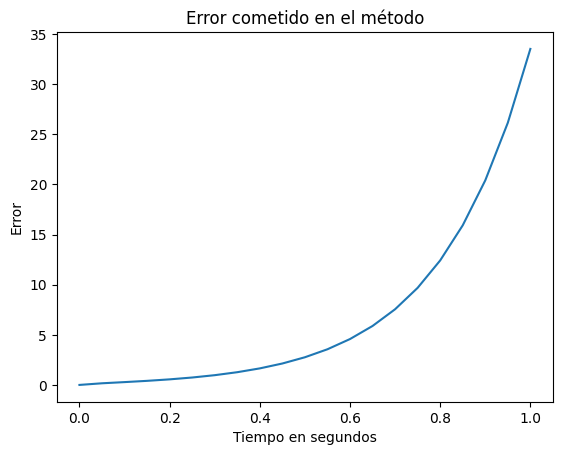

In [192]:
er = ECM(x, y, u_ap, u_ex)
print('El error máximo cometido para el método es de: ', er.max())
GraphEr(er)

In [178]:
i = 2
j = 2
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
to = a[i-1:i+2, j-1:j+2]
to = np.arange(5-1)
print(to)

[0 1 2 3]
